In [90]:
import yaml, glob
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import tqdm

In [2]:
config = 'config.yml'
with open(config) as f:
    conf = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
print(conf)
input_cols = conf['tempvars'] + conf['tempdewvars'] + conf['ugrdvars'] + conf['vgrdvars']
output_cols = conf['outputvars']

{'tempvars': ['TEMP_C_0_m', 'TEMP_C_10000_m', 'TEMP_C_1000_m', 'TEMP_C_10250_m', 'TEMP_C_10500_m', 'TEMP_C_10750_m', 'TEMP_C_11000_m', 'TEMP_C_11250_m', 'TEMP_C_11500_m', 'TEMP_C_11750_m', 'TEMP_C_12000_m', 'TEMP_C_12250_m', 'TEMP_C_12500_m', 'TEMP_C_1250_m', 'TEMP_C_12750_m', 'TEMP_C_13000_m', 'TEMP_C_13250_m', 'TEMP_C_13500_m', 'TEMP_C_13750_m', 'TEMP_C_14000_m', 'TEMP_C_14250_m', 'TEMP_C_14500_m', 'TEMP_C_14750_m', 'TEMP_C_15000_m', 'TEMP_C_1500_m', 'TEMP_C_15250_m', 'TEMP_C_15500_m', 'TEMP_C_15750_m', 'TEMP_C_16000_m', 'TEMP_C_16250_m', 'TEMP_C_16500_m', 'TEMP_C_1750_m', 'TEMP_C_2000_m', 'TEMP_C_2250_m', 'TEMP_C_2500_m', 'TEMP_C_250_m', 'TEMP_C_2750_m', 'TEMP_C_3000_m', 'TEMP_C_3250_m', 'TEMP_C_3500_m', 'TEMP_C_3750_m', 'TEMP_C_4000_m', 'TEMP_C_4250_m', 'TEMP_C_4500_m', 'TEMP_C_4750_m', 'TEMP_C_5000_m', 'TEMP_C_500_m', 'TEMP_C_5250_m', 'TEMP_C_5500_m', 'TEMP_C_5750_m', 'TEMP_C_6000_m', 'TEMP_C_6250_m', 'TEMP_C_6500_m', 'TEMP_C_6750_m', 'TEMP_C_7000_m', 'TEMP_C_7250_m', 'TEMP_C_7500

In [4]:
arr = sorted(glob.glob(conf['asos_path']+'*'))
arr[-10:]

['/glade/p/cisl/aiml/ai2es/winter_ptypes/precip_rap/ASOS_mixture/ASOS_rap_20210418.parquet',
 '/glade/p/cisl/aiml/ai2es/winter_ptypes/precip_rap/ASOS_mixture/ASOS_rap_20210419.parquet',
 '/glade/p/cisl/aiml/ai2es/winter_ptypes/precip_rap/ASOS_mixture/ASOS_rap_20210420.parquet',
 '/glade/p/cisl/aiml/ai2es/winter_ptypes/precip_rap/ASOS_mixture/ASOS_rap_20210421.parquet',
 '/glade/p/cisl/aiml/ai2es/winter_ptypes/precip_rap/ASOS_mixture/ASOS_rap_20210422.parquet',
 '/glade/p/cisl/aiml/ai2es/winter_ptypes/precip_rap/ASOS_mixture/ASOS_rap_20210427.parquet',
 '/glade/p/cisl/aiml/ai2es/winter_ptypes/precip_rap/ASOS_mixture/ASOS_rap_20210428.parquet',
 '/glade/p/cisl/aiml/ai2es/winter_ptypes/precip_rap/ASOS_mixture/ASOS_rap_20210429.parquet',
 '/glade/p/cisl/aiml/ai2es/winter_ptypes/precip_rap/ASOS_mixture/ASOS_rap_20210430.parquet',
 '/glade/p/cisl/aiml/ai2es/winter_ptypes/precip_rap/ASOS_mixture/ASOS_rap_20210501.parquet']

In [92]:
df = pd.concat([pd.read_parquet(x) for x in tqdm.tqdm(arr)])

100%|██████████| 1884/1884 [06:52<00:00,  4.57it/s]


In [93]:
df.shape

(4029725, 407)

In [6]:
df['day'] = df['datetime'].apply(lambda x: str(x).split(' ')[0])

In [ ]:
# df = pd.concat([pd.read_parquet(x) for x in arr[:100]])

### Split the data

In [7]:
splitter = GroupShuffleSplit(n_splits=1, train_size=0.9)

In [8]:
train_idx, test_idx = list(splitter.split(df, groups=df['day']))[0]
train_data, test_data = df.iloc[train_idx], df.iloc[test_idx]

In [9]:
splitter = GroupShuffleSplit(n_splits=1, train_size=0.885)
train_idx, valid_idx = list(splitter.split(train_data, groups=train_data['day']))[0]
train_data, valid_data = train_data.iloc[train_idx], train_data.iloc[valid_idx]

In [10]:
train_data.shape

(8496, 408)

In [11]:
test_data.shape

(1650, 408)

In [12]:
valid_data.shape

(3345, 408)

### Preprocessing the data

In [13]:
scaler_x = StandardScaler()

In [14]:
x_train = scaler_x.fit_transform(train_data[input_cols])

In [15]:
x_valid = scaler_x.transform(valid_data[input_cols])

In [45]:
import numpy as np

In [61]:
def one_hot(x):
    a = np.zeros(len(output_cols))
    a[x] = 1
    return a

train_data['label'] = train_data[output_cols].idxmax(axis=1).apply(lambda x: one_hot(output_cols.index(x)))
y_train = train_data['label'].to_numpy()
y_train = np.vstack(y_train)
y_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [57]:
valid_data['label'] = valid_data[output_cols].idxmax(axis=1).apply(lambda x: one_hot(output_cols.index(x)))
y_valid = valid_data['label'].to_numpy()

In [60]:
y_valid = np.vstack(y_valid)
y_valid.shape

(3345, 4)

### Train Model

In [18]:
import tensorflow as tf

In [29]:
def build_model(input_size, hidden_size, output_size):
    model = tf.keras.models.Sequential(
        [tf.keras.layers.Dense(input_size, activation='relu'),
        tf.keras.layers.Dense(hidden_size, activation='relu'),
        tf.keras.layers.Dense(output_size, activation='softmax')]
    )
    return model

In [30]:
model = build_model(len(input_cols), 100, len(output_cols))

In [31]:
model.build((32, len(input_cols)))

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (32, 268)                 72092     
                                                                 
 dense_7 (Dense)             (32, 100)                 26900     
                                                                 
 dense_8 (Dense)             (32, 4)                   404       
                                                                 
Total params: 99,396
Trainable params: 99,396
Non-trainable params: 0
_________________________________________________________________


In [34]:
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [43]:
loss = tf.keras.losses.CategoricalCrossentropy()

In [33]:
# x = tf.ones((32, len(input_cols)))
# model(x)

<tf.Tensor: shape=(32, 4), dtype=float32, numpy=
array([[0.10436485, 0.30698   , 0.25965023, 0.32900488],
       [0.10436485, 0.30698   , 0.25965023, 0.32900488],
       [0.10436485, 0.30698   , 0.25965023, 0.32900488],
       [0.10436485, 0.30698   , 0.25965023, 0.32900488],
       [0.10436485, 0.30698   , 0.25965023, 0.32900488],
       [0.10436485, 0.30698   , 0.25965023, 0.32900488],
       [0.10436485, 0.30698   , 0.25965023, 0.32900488],
       [0.10436485, 0.30698   , 0.25965023, 0.32900488],
       [0.10436485, 0.30698   , 0.25965023, 0.32900488],
       [0.10436485, 0.30698   , 0.25965023, 0.32900488],
       [0.10436485, 0.30698   , 0.25965023, 0.32900488],
       [0.10436485, 0.30698   , 0.25965023, 0.32900488],
       [0.10436485, 0.30698   , 0.25965023, 0.32900488],
       [0.10436485, 0.30698   , 0.25965023, 0.32900488],
       [0.10436485, 0.30698   , 0.25965023, 0.32900488],
       [0.10436485, 0.30698   , 0.25965023, 0.32900488],
       [0.10436485, 0.30698   , 0.25965

In [49]:
model.compile(loss=loss, optimizer=optimizer, metrics='acc', run_eagerly=True) #metrics could be list

In [62]:
model.fit(x_train, y_train, validation_data=(x_valid, y_valid), shuffle=True, epochs=100) #set as variable

Epoch 1/100
266/266 [==============================] - 4s 10ms/step - loss: 0.0858 - acc: 0.9708 - val_loss: 0.2376 - val_acc: 0.9184
Epoch 2/100
266/266 [==============================] - 3s 10ms/step - loss: 0.0557 - acc: 0.9793 - val_loss: 0.1331 - val_acc: 0.9635
Epoch 3/100
266/266 [==============================] - 3s 11ms/step - loss: 0.0489 - acc: 0.9790 - val_loss: 0.1664 - val_acc: 0.9632
Epoch 4/100
266/266 [==============================] - 3s 10ms/step - loss: 0.0417 - acc: 0.9848 - val_loss: 0.1488 - val_acc: 0.9543
Epoch 5/100
266/266 [==============================] - 3s 10ms/step - loss: 0.0417 - acc: 0.9818 - val_loss: 0.1506 - val_acc: 0.9620
Epoch 6/100
266/266 [==============================] - 3s 10ms/step - loss: 0.0377 - acc: 0.9838 - val_loss: 0.1787 - val_acc: 0.9668
Epoch 7/100
266/266 [==============================] - 3s 10ms/step - loss: 0.0341 - acc: 0.9858 - val_loss: 0.2199 - val_acc: 0.9590
Epoch 8/100
266/266 [==============================] - 3s 10ms

In [63]:
val_pred = model.predict(x_valid)

In [64]:
val_pred

array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       ...,
       [1.0000000e+00, 2.1562981e-18, 0.0000000e+00, 1.1833383e-36],
       [1.0000000e+00, 2.9670084e-09, 5.0603455e-27, 1.9219380e-18],
       [9.9991882e-01, 5.7764770e-05, 3.7234716e-18, 2.3411862e-05]],
      dtype=float32)

In [65]:
y_valid

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [67]:
preds = np.argmax(val_pred, 1)

In [68]:
labels = np.argmax(y_valid,1)

In [69]:
(preds == labels).mean()

0.9461883408071748

In [70]:
class_weight = {0:1.0, 1:10.0, 2:10.0, 3:10.0} #class_weights=class_weights in model.fit

In [71]:
train_data['label'].value_counts()

[1.0, 0.0, 0.0, 0.0]    1
[1.0, 0.0, 0.0, 0.0]    1
[1.0, 0.0, 0.0, 0.0]    1
[1.0, 0.0, 0.0, 0.0]    1
[1.0, 0.0, 0.0, 0.0]    1
                       ..
[1.0, 0.0, 0.0, 0.0]    1
[1.0, 0.0, 0.0, 0.0]    1
[1.0, 0.0, 0.0, 0.0]    1
[1.0, 0.0, 0.0, 0.0]    1
[1.0, 0.0, 0.0, 0.0]    1
Name: label, Length: 8496, dtype: int64

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    # plt.xlim(-0.5, len(np.unique(y))-0.5)
    # plt.ylim(len(np.unique(y))-0.5, -0.5)
    return ax

Confusion matrix, without normalization
[[2289  120    3]
 [  49  876    0]
 [   0    8    0]]
Normalized confusion matrix
[[0.95 0.05 0.  ]
 [0.05 0.95 0.  ]
 [0.   1.   0.  ]]


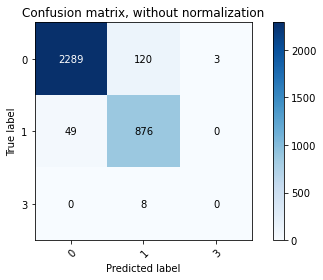

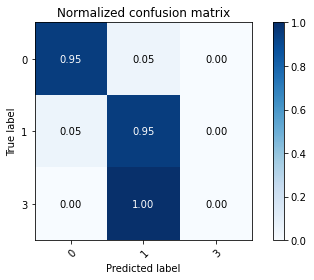

In [87]:
np.set_printoptions(precision=2)
class_names = [str(x) for x in sorted(set(labels))]

# Plot non-normalized confusion matrix
plot_confusion_matrix(labels, preds, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(labels, preds, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()